# Project report
### -- Feature importance and selection
#### Lin Meng

## Overview:
The goal of this project is to implement various feature importance algorithms, and get a better understanding of their strengths and weaknesses in different contexts. This report discusses about some of details and path I've taken to accomplish the goal. 

The source code is in the _featimp.py_ file, we import it here to present some of the examples and visualizations.

In [47]:
%run featimp

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

## Dataset

To start with, we first load our toy dataset, which is the Auto-mpg dataset from UCI Machine Learning Repository.

In [3]:
auto = pd.read_csv("auto-mpg.csv")
print(auto.shape)
auto.head()

(398, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


Here, we dropped the last column and removed some missing values. It ended up with 392 observations. _mpg_ is our target, the rest 7 columns are our features.

In [4]:
auto.drop(columns="car name", inplace=True)
auto = auto[auto.horsepower != "?"]

In [5]:
X = auto.iloc[:, 1:]
y = auto["mpg"]

## Section I: Data-based strategies

### Spearman

The most straightforward technique is to rank their correlation coefficient with the target. The higher the correlation, the more predictive the feature could be. If we look at the example data, we would get the following result. It's more helpful to visualize the which one is more important.

**Note**: we took the absolute value since the magnitude matters in determining feature importance.

In [97]:
spearmancc = rank_corr(X, y)
spearmancc

,feature,score
0,cylinders,0.823175
1,displacement,0.855234
2,horsepower,0.419109
3,weight,0.875585
4,acceleration,0.441539
5,model year,0.574841
6,origin,0.580482


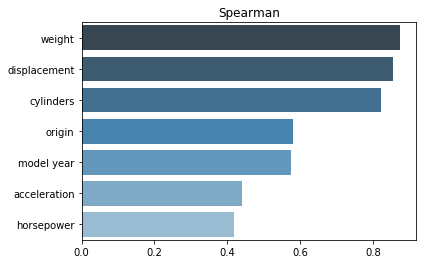

In [98]:
plot_imp(spearmancc, "Spearman", sort=True)

### mRMR

One drawback of simply looking at correlation coefficient is that codependent features may both get high scores. However, their correlation should also be taken into account since the additional features wouldn't give more power in predicting the target.

If we want to briefly explain how mRMR works:

1. Initial an empty feature set $S$.
2. For every round, loop through the available features.
    - Calculate the Spearman coefficient with $y$.
    - Calculate the sum of Spearman coefficients with all the features in $S$.
    - Subtract the first term by the second.
3. The final outcome is the mRMR score, in which we exclude the effect of codependence.

In [99]:
mrmr = mRMR(X, y)
mrmr

,feature,score
0,weight,0.875585
1,model year,0.293860
2,displacement,0.229127
3,cylinders,0.116299
4,origin,0.051280
5,acceleration,0.064241
6,horsepower,0.077758


It's interesting to notice _model year_ climbs interms of feature importance possibly because there are some codependent among other features. This time, _weight_ definitely stands out compared to our previous result.

Also, the mRMR algorithm directly gives us the most importance features one by one. So we don't need to sort by their scores. In this case, we result in having some more important features getting lower scores.

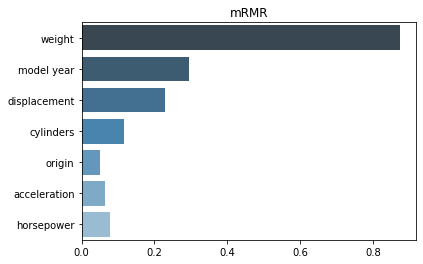

In [100]:
plot_imp(mrmr, "mRMR", sort=False)

## Section II: Model-based strategies

### Permutation importance

By permutation, we permute the values within each feature at a time, and keep track of the difference in evaluation metrics. If the metric changes significantly, it may indicate a very important feature has been permuted.

The model has been trained beforehand, and we don't need to refit the model since we run this experiment on the test set. 

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

We use Random Forest as our default model, and train the model at first.

In [106]:
rf = RandomForestRegressor(oob_score=True)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [107]:
permutation = permutation_importances(rf, X_test, y_test)
permutation

,feature,score
0,cylinders,0.016792
1,displacement,0.172693
2,horsepower,0.025088
3,weight,0.220021
4,acceleration,0.011635
5,model year,0.235438
6,origin,0.012547


Based on the result, there seems to appear 2 groups of features. A potential problem with permutation importance is that correlated features tend to be overestimated, which could be true in our example.

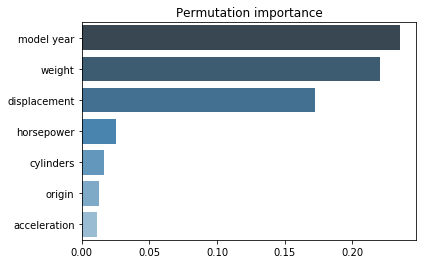

In [108]:
plot_imp(permutation, "Permutation importance", sort=True)

### Drop column importances

Another approach is to see how much the metric changes due to the drop of one column. Different from above, we look at the OOB score in this context. Additionally, we need to refit the model every time we drop a column, but specify a _random_state_ to make the results comparable.

In [110]:
rf = RandomForestRegressor(random_state=24, oob_score=True)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=24, verbose=0, warm_start=False)

In [112]:
dropcol = dropcol_importances(rf, X, y)
dropcol

,feature,score
0,cylinders,-0.000292
1,displacement,0.011903
2,horsepower,0.003151
3,weight,0.006995
4,acceleration,0.004808
5,model year,0.098694
6,origin,0.001016


We got different results again. _model year_ is leading, but the rankings are more consistent with what we have for mRMR.

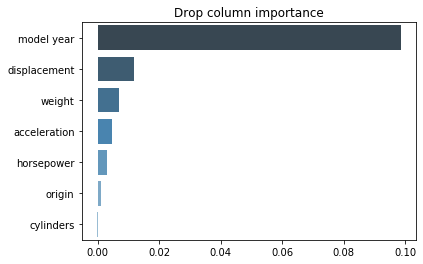

In [113]:
plot_imp(dropcol, "Drop column importance", sort=True)

## Section III: Comparing strategies

In order to gain a better understanding of how these algorithms work differently, we took the top k important features and fit different models to make a comparison. In the first part, we had the Spearman rank algorithm with three models: linear regression, random forest and gradient boosting. We can see from the plot, with the inclusion of the 5th feature, all models had better performances.

In [7]:
top_k_score_1 = top_features(X, y, algo=rank_corr)
top_k_score_1

,top_k,lr_score,rf_score,gbm_score
0,1,18.676617,4.837870,9.395963
1,2,18.291602,3.118396,7.217963
2,3,18.271809,2.958745,7.103754
3,4,17.868212,2.444430,7.118504
4,5,11.003502,1.178774,2.638511
5,6,10.890184,1.022385,2.182046
6,7,10.847481,1.026166,2.256238


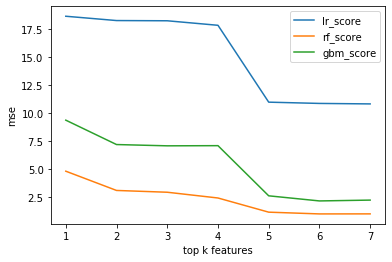

In [9]:
fig, ax = plt.subplots()
sns.lineplot(x="top_k", y="lr_score", data=top_k_score_1, label="lr_score")
sns.lineplot(x="top_k", y="rf_score", data=top_k_score_1, label="rf_score")
sns.lineplot(x="top_k", y="gbm_score", data=top_k_score_1, label="gbm_score")
ax.set_xlabel("top k features")
ax.set_ylabel("mse")
ax.legend()
plt.show()

In terms of different algorithms, we took the example of Spearman v.s. mRMR. Despite the two start and end around the same level, mRMR renders the model to improve a lot after including the 2nd feature, while Spearman requires more features to achieve the same model fit.

In [158]:
top_k_score_2 = top_features(X, y, algo=mRMR)
top_k_score_2

,top_k,lr_score,rf_score,gbm_score
0,1,18.676617,4.903298,9.395963
1,2,11.655490,1.599825,3.480290
2,3,11.655383,1.274923,2.860884
3,4,11.626824,1.233157,2.920330
4,5,11.611197,1.132436,2.519302
5,6,11.590171,1.027181,2.236675
6,7,10.847481,1.094780,2.256238


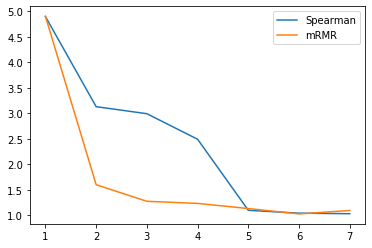

In [159]:
fig, ax = plt.subplots()
sns.lineplot(x="top_k", y="rf_score", data=top_k_score_1, label="Spearman")
sns.lineplot(x="top_k", y="rf_score", data=top_k_score_2, label="mRMR")
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend()
plt.show()

## Section IV: Automatic feature selection algorithm

Another way to take advantage of the feature importance is by looking at how the choice of features impact the validation performance. We used the drop column feature importance to implement the auto-selection process.

The idea is every time we have a new ranking of exsting features, we dropped the least importance one and write down the validation score. If the score is higher, we recompute and the feature importance and droped the last one and repeat, until the score starts to decrease.

As this may work fine with less features, there might be some local optimum that stops the procedure. During our experiments, we had some different outcomes if _random_state_ is not specified. For instance, the results below indicate we dropped _cylinders_ first, the MSE of validation goes down to 5.98, which is an improvement from the baseline. In the next step, we droppped _origin_ and see an improvement again. However, after we dropped _displacement_, the MSE becomes larger, so we stop there. We would end up having 4 features.

In [188]:
rf = RandomForestRegressor(oob_score=True)
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [190]:
auto_select(rf, X, y)

Dropped cylinders
score 5.9781 Baseline 6.8659
Dropped origin
score 6.1499 Baseline 6.8659
Dropped acceleration
score 5.8370 Baseline 6.8659
Dropped displacement
score 9.3891 Baseline 6.8659


array(['model year', 'weight', 'horsepower', 'displacement'], dtype=object)

## Section V: Variance of feature importances

So, how robust are the importance scores we got? We could test it on the bootstrapped data several times and compare the variances. For our dataset, the variance of the features are relatively small, except for the last 3 features.

In [51]:
variance_imp = var_imp(X, y, mRMR)
variance_imp

,feature,score,std
0,cylinders,0.870366,0.011453
1,displacement,0.302807,0.022320
2,horsepower,0.231701,0.017496
3,weight,0.118951,0.014949
4,acceleration,0.068434,0.024490
5,model year,0.077346,0.016843
6,origin,0.069712,0.017212


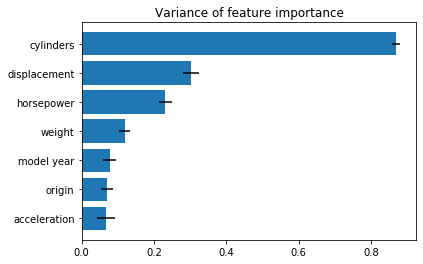

In [53]:
variance_imp.sort_values(by="score", inplace=True)

fig, ax = plt.subplots()
ax.barh(variance_imp.feature, variance_imp.score, xerr=variance_imp["std"])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Variance of feature importance")
plt.show()

## Summary:

- Different algorithms often yield different results, it would be helpful to pick the most appropriate one based on the context of the problem.
- Data-based approaches are more intuitive and efficient while model-based ones have more applications.